In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer

# loads the dataframes
semi_leptonic_df = pd.read_hdf('/storage/bk17414/ForStudents/2021_CMS_ML/ml_postproc/TTToSemiLeptonic/df_ml_inputs.hd5')
higgs_df = pd.read_hdf('/storage/bk17414/ForStudents/2021_CMS_ML/ml_postproc/ttH125/df_ml_inputs.hd5')

# labels signal vs background
semi_leptonic_df['signal'] = 0
higgs_df['signal'] = 1

# combines the dataframes and randomly shuffles the rows
full_df = semi_leptonic_df.append(higgs_df, ignore_index=True)
full_df = shuffle(full_df)

In [9]:
# removes unnecessary columns
useful_cols = ['BiasedDPhi',
               'DiJet_mass',
               'HT', 
               'InputMet_InputJet_mindPhi',
               'InputMet_pt', 
               'MHT_pt',
               'MinChi',
               'MinOmegaHat',
               'MinOmegaTilde',
               'ncleanedBJet', 
               'ncleanedJet', 
               'signal',]

df = full_df[useful_cols]

# creates some new features for the NN
df['totalJets'] = df['ncleanedJet'] + df['ncleanedBJet']
df['totalJetMass'] = full_df['cleanedJet_mass'].apply(lambda x: sum(x))
df['totalJetArea'] = full_df['cleanedJet_area'].apply(lambda x: sum(x))
df['totalJet_pt'] = full_df['cleanedJet_pt'].apply(lambda x: sum(x)) # seems to contradict HT most of the time

# splits data into training and validation
X, y = df.drop('signal', axis=1, ), df['signal']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

print('Removed Columns:', [col for col in full_df.columns if col not in useful_cols])
print('Included Columns:', list(X.columns))

columns = X.columns
X_train.head()

Removed Columns: ['dataset', 'entry', 'InputMet_phi', 'MHT_phi', 'cleanedJet_area', 'cleanedJet_btagDeepB', 'cleanedJet_chHEF', 'cleanedJet_eta', 'cleanedJet_mass', 'cleanedJet_neHEF', 'cleanedJet_phi', 'cleanedJet_pt', 'hashed_filename', 'weight_nominal', 'xs_weight']
Included Columns: ['BiasedDPhi', 'DiJet_mass', 'HT', 'InputMet_InputJet_mindPhi', 'InputMet_pt', 'MHT_pt', 'MinChi', 'MinOmegaHat', 'MinOmegaTilde', 'ncleanedBJet', 'ncleanedJet', 'totalJets', 'totalJetMass', 'totalJetArea', 'totalJet_pt']


,BiasedDPhi,DiJet_mass,HT,InputMet_InputJet_mindPhi,InputMet_pt,MHT_pt,MinChi,MinOmegaHat,MinOmegaTilde,ncleanedBJet,ncleanedJet,totalJets,totalJetMass,totalJetArea,totalJet_pt
327253,-3.120597,327.981802,1002.078979,2.082031,349.500,366.687866,0.884824,0.884823,0.871718,3,9,12,116.398438,4.309082,1002.078915
45330,0.043261,76.352534,597.152771,1.123047,245.125,242.307938,0.355119,0.355119,0.307100,0,5,5,70.199219,2.283936,597.152740
262152,2.307626,89.554310,248.547806,2.494141,210.500,232.551224,1.570796,0.898212,0.329447,1,2,3,33.195312,1.027344,248.547806
262466,0.601100,635.234945,477.025818,1.639648,246.125,258.673309,1.208264,1.035918,0.623011,1,5,6,72.601562,2.473633,477.025829
230441,-2.766593,81.984883,297.131042,2.941406,338.000,293.244385,1.570796,0.920323,0.320155,0,2,2,36.687500,0.947510,297.131058


In [3]:
from sklearn.preprocessing import StandardScaler
import math

scaler = StandardScaler()

# takes the log of each column to remove the skewness in the distributions
def remove_skewness(df):
    # BiasedDPhi has negative values so needs to be shifted
    df['BiasedDPhi'] += math.pi

    for col_name in X_train.columns:
        if col_name not in ['ncleanedBJet', 'ncleanedJet', 'totalJets', 'totalJetArea', 'BiasedDPhi']:
            df[col_name] = np.log(df[col_name])


remove_skewness(X_train)
remove_skewness(X_test)

# scales features so they all have the same mean and variance
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=columns)

X_train.head()

,BiasedDPhi,DiJet_mass,HT,InputMet_InputJet_mindPhi,InputMet_pt,MHT_pt,MinChi,MinOmegaHat,MinOmegaTilde,ncleanedBJet,ncleanedJet,totalJets,totalJetMass,totalJetArea,totalJet_pt
0,-0.808316,1.028029,2.099550,0.703672,1.231186,1.512152,-1.143907,-0.316433,1.089230,2.773475,2.659962,3.106300,1.598665,2.551148,2.099550
1,1.617312,-1.047796,0.858003,-0.547933,-0.365465,-0.366591,-4.270781,-4.890945,-2.029632,-0.918507,0.330012,-0.081889,0.459340,0.129397,0.858003
2,3.353327,-0.820668,-1.244275,1.069848,-1.050881,-0.552964,0.821913,-0.241181,-1.819643,0.312154,-1.417450,-0.992800,-1.228029,-1.373286,-1.244275
3,2.044989,1.969439,0.319319,0.219367,-0.347140,-0.070218,-0.076820,0.473541,0.085073,0.312154,0.330012,0.373567,0.535154,0.356245,0.319319
4,-0.536912,-0.946434,-0.816071,1.404280,1.080594,0.498620,0.821913,-0.119327,-1.905174,-0.918507,-1.417450,-1.448255,-1.002663,-1.468754,-0.816071


In [10]:
# checks for null values in df
X_train.isnull().values.any()

False

In [5]:
# binary classifier neural network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras.backend as K
from sklearn.utils import class_weight

# sets hyperparameters
learning_rate_init = 0.0001
activation='tanh'
batch_size = 16
epochs = 20 #70
patience = 5
loss = 'binary_crossentropy'
beta_1 = 0.9
beta_2 = 0.999
epsilon = 1e-8

optimizer = keras.optimizers.Adam(
                learning_rate=learning_rate_init,
                beta_1=beta_1,
                beta_2=beta_2,
                epsilon=epsilon,
            )

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='AUC'),
      f1_score,
]

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='f1_score', 
    verbose=1,
    patience=patience,
    mode='max',
    restore_best_weights=True)

# weighting the classes lowers accuracy and precision but increases recall and f1 score
#class_weights = [1/float(full_df['xs_weight'].loc[full_df['signal'] == _class].mode()) for _class in np.unique(y_train)]
#class_weights = [i / min(class_weights) for i in class_weights]
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}
print(class_weights)

# saves the network at regular intervals so you can pick the best version
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='/tmp/checkpoint',
    monitor="f1_score",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="max",
    save_freq="epoch",
)

{0: 0.6676178944857293, 1: 1.9914875333986761}


2021-11-08 16:10:06.479443: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-08 16:10:06.479861: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-08 16:10:06.486206: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [6]:
def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
   
  # create model
  model = keras.Sequential([
      keras.layers.Dense(100, input_dim=X_train.shape[1], activation=activation),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(100, activation=activation),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(100, activation=activation),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(100, activation=activation),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=optimizer,
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [7]:
model = make_model()

baseline_history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    class_weight=class_weights,
    epochs=epochs,
    callbacks=[early_stopping],
    validation_data=(X_test, y_test),)

2021-11-08 16:11:17.690447: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-08 16:11:17.703764: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2394015000 Hz


Epoch 1/20
18541/18541 [==============================] - 206s 11ms/step - loss: 0.5580 - tp: 27566.4194 - fp: 32621.7251 - tn: 78517.9514 - fn: 9637.9025 - accuracy: 0.7046 - precision: 0.4489 - recall: 0.7511 - AUC: 0.7897 - f1_score: 0.5355 - val_loss: 0.5524 - val_tp: 18938.0000 - val_fp: 22413.0000 - val_tn: 51644.0000 - val_fn: 5888.0000 - val_accuracy: 0.7138 - val_precision: 0.4580 - val_recall: 0.7628 - val_AUC: 0.8054 - val_f1_score: 0.5470
Epoch 2/20
18541/18541 [==============================] - 173s 9ms/step - loss: 0.5447 - tp: 27318.5159 - fp: 30746.3856 - tn: 80436.2944 - fn: 9842.8023 - accuracy: 0.7256 - precision: 0.4695 - recall: 0.7348 - AUC: 0.7993 - f1_score: 0.5461 - val_loss: 0.5230 - val_tp: 18040.0000 - val_fp: 19331.0000 - val_tn: 54726.0000 - val_fn: 6786.0000 - val_accuracy: 0.7359 - val_precision: 0.4827 - val_recall: 0.7267 - val_AUC: 0.8104 - val_f1_score: 0.5529
Epoch 3/20
18541/18541 [==============================] - 169s 9ms/step - loss: 0.5400 - tp

In [11]:
model2 = make_model()

baseline_history2 = model2.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    class_weight=class_weights,
    epochs=epochs,
    callbacks=[early_stopping],
    validation_data=(X_test, y_test),)

Epoch 1/20
18541/18541 [==============================] - 194s 10ms/step - loss: 0.6629 - tp: 42505.3079 - fp: 65327.7268 - tn: 119824.7382 - fn: 19569.2254 - accuracy: 0.6668 - precision: 0.4059 - recall: 0.6837 - AUC: 0.7390 - f1_score: 0.4185 - val_loss: 0.6185 - val_tp: 19610.0000 - val_fp: 36095.0000 - val_tn: 37962.0000 - val_fn: 5216.0000 - val_accuracy: 0.5822 - val_precision: 0.3520 - val_recall: 0.7899 - val_AUC: 0.7001 - val_f1_score: 0.4677
Epoch 2/20
18541/18541 [==============================] - 181s 10ms/step - loss: 0.6341 - tp: 27882.0450 - fp: 51760.8885 - tn: 59346.3939 - fn: 9354.6710 - accuracy: 0.5866 - precision: 0.3496 - recall: 0.7477 - AUC: 0.6819 - f1_score: 0.4551 - val_loss: 0.6212 - val_tp: 19238.0000 - val_fp: 34018.0000 - val_tn: 40039.0000 - val_fn: 5588.0000 - val_accuracy: 0.5995 - val_precision: 0.3612 - val_recall: 0.7749 - val_AUC: 0.7120 - val_f1_score: 0.4727
Epoch 3/20
18541/18541 [==============================] - 184s 10ms/step - loss: 0.6245 

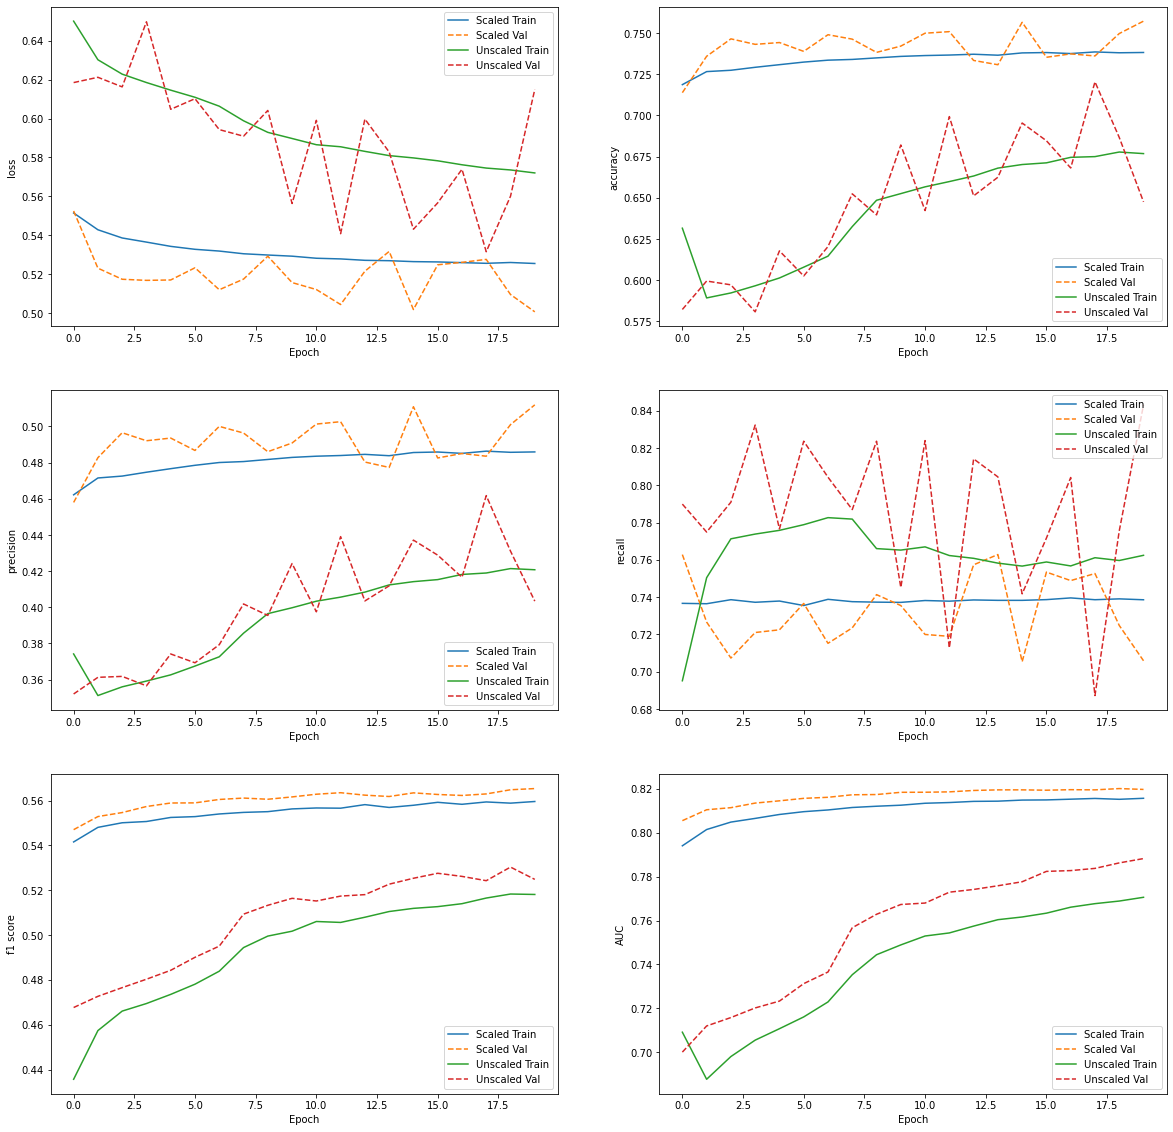

In [12]:
metrics = ['loss', 'accuracy', 'precision', 'recall', 'f1_score', 'AUC']
fig = plt.figure(figsize=(20, 20))

for n, metric in enumerate(metrics):
  name = metric.replace("_"," ")
  plt.subplot(3,2,n+1)
  plt.plot(baseline_history.epoch, baseline_history.history[metric], label='Scaled Train')
  plt.plot(baseline_history.epoch, baseline_history.history['val_'+metric],linestyle="--", label='Scaled Val')

  plt.plot(baseline_history2.epoch, baseline_history2.history[metric], label='Unscaled Train')
  plt.plot(baseline_history2.epoch, baseline_history2.history['val_'+metric],linestyle="--", label='Unscaled Val')

  plt.xlabel('Epoch')
  plt.ylabel(name)

  plt.legend()

plt.show()

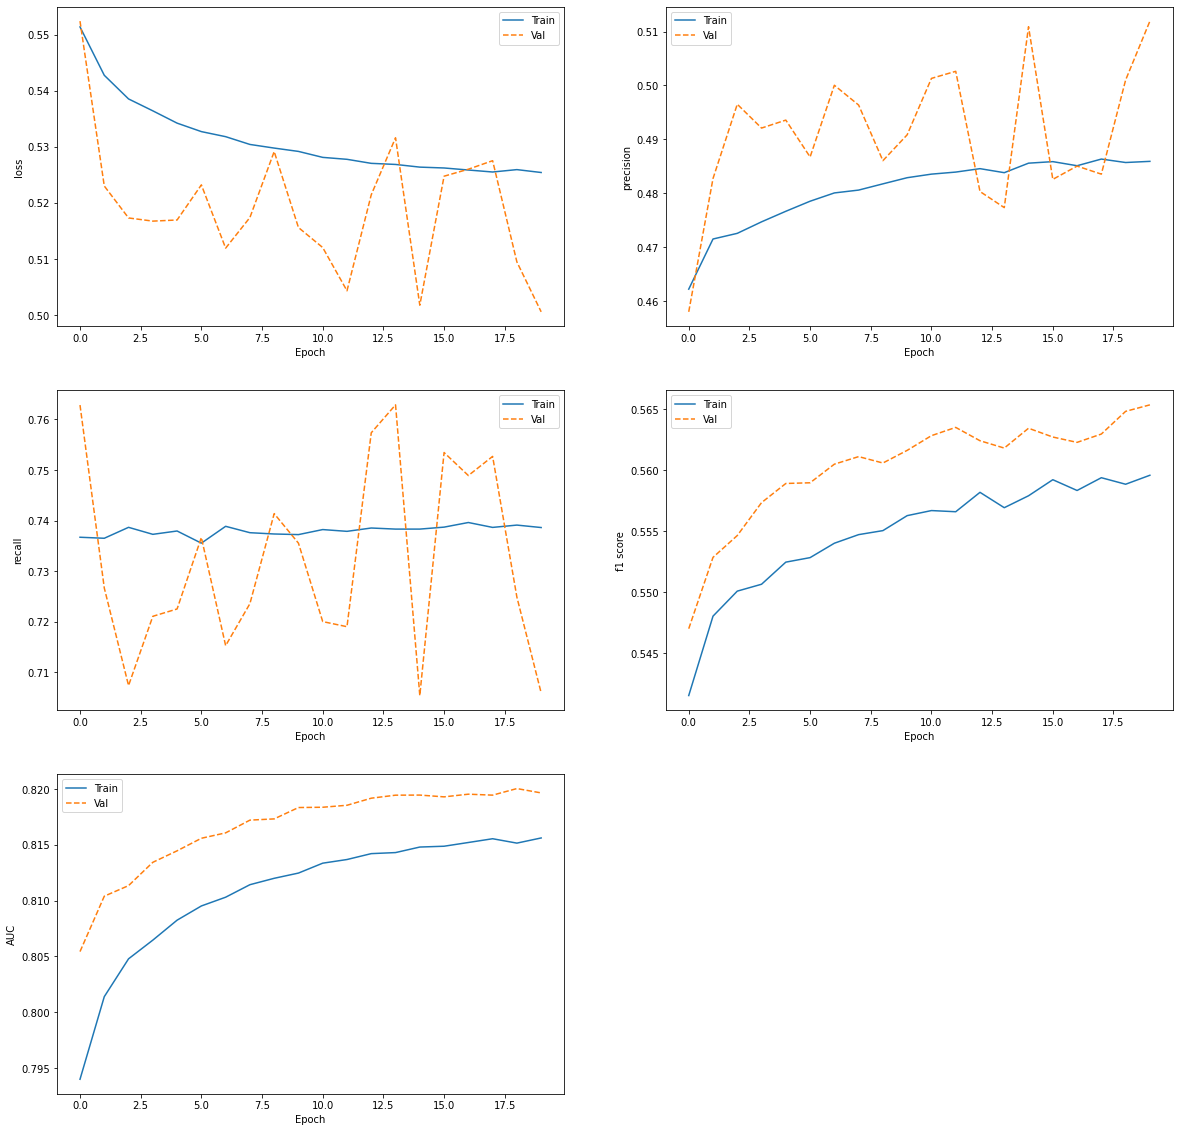

In [8]:
def plot_metrics(history):
  metrics = ['loss', 'accuracy', 'precision', 'recall', 'f1_score', 'AUC']
  fig = plt.figure(figsize=(20, 20))

  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ")
    plt.subplot(3,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             linestyle="--", label='Val')
  
    plt.xlabel('Epoch')
    plt.ylabel(name)

    plt.legend()

plot_metrics(baseline_history)

loss :  0.17625048756599426
tp :  1119.0
fp :  756.0
tn :  73301.0
fn :  4634.0
accuracy :  0.932464599609375
precision :  0.5968000292778015
recall :  0.19450721144676208
AUC :  0.8916658759117126
f1_score :  0.21088507771492004

Background Events Detected (True Negatives):  73301
Background Events Incorrectly Detected (False Positives):  756
Signals Missed (False Negatives):  4634
Signals Detected (True Positives):  1119
Total Signals:  5753


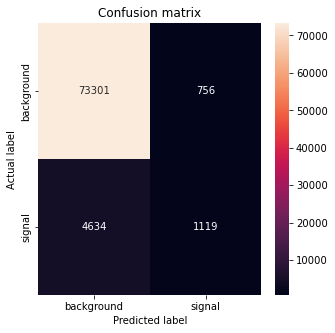

In [14]:
from sklearn.metrics import confusion_matrix

train_predictions_baseline = model.predict(X_train, batch_size=batch_size)
test_predictions_baseline = model.predict(X_test, batch_size=batch_size)

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d", xticklabels=['background', 'signal'], yticklabels=['background', 'signal'])

  plt.title('Confusion matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Background Events Detected (True Negatives): ', cm[0][0])
  print('Background Events Incorrectly Detected (False Positives): ', cm[0][1])
  print('Signals Missed (False Negatives): ', cm[1][0])
  print('Signals Detected (True Positives): ', cm[1][1])
  print('Total Signals: ', np.sum(cm[1]))

baseline_results = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)

for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

#accuracy :  0.7557113170623779
#precision :  0.509791910648346
#recall :  0.7025296092033386
#AUC :  0.8184635043144226
#f1_score :  0.5774734616279602


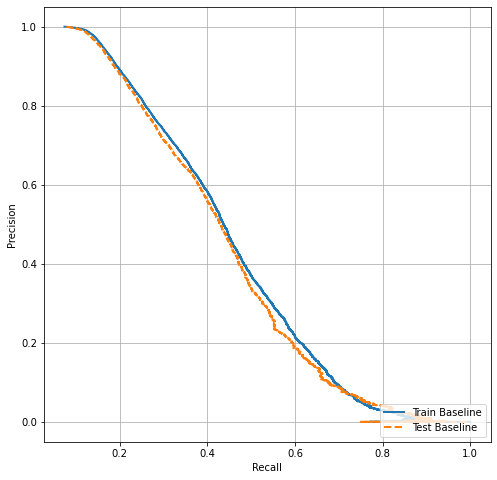

In [15]:
from sklearn.metrics import precision_recall_curve

train_precision, train_recall, _ = precision_recall_curve(y_train, train_predictions_baseline)
test_precision, test_recall, _ = precision_recall_curve(y_test, test_predictions_baseline)

fig = plt.figure(figsize=(8, 8))

plt.plot(train_precision, train_recall, label='Train Baseline', linewidth=2)
plt.plot(test_precision, test_recall, label='Test Baseline', linewidth=2, linestyle='--')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)

plt.legend(loc='lower right')
plt.show()

In [19]:
# saves the model so I don't have to retrain it everytime
model.save('binary_classifier_model_tensorflow')

INFO:tensorflow:Assets written to: binary_classifier_model_tensorflow/assets


In [ ]:
# loads in the pretrained keras model
model = keras.models.load_model('binary_classifier_model_tensorflow')

In [49]:
from lime import lime_tabular

class_names = ['background', 'signal']
explainer = lime_tabular.LimeTabularExplainer(X_train.values, 
                                              feature_names=X.columns, 
                                              class_names=class_names, 
                                              discretize_continuous=True,
                                              mode='classification')

def event_type(i):
    return 'signal' if y_test.values[i] == 1 else 'background'

preds = model.predict(X_test)

In [51]:
# explains a random event from the testing data

i = np.random.randint(0, X_test.shape[0])
prediction = 'signal' if preds[i][0] >= 0.5 else 'background'
print('Event', i, '\nCorrect answer:', event_type(i), '\nPrediction:', prediction)

exp = explainer.explain_instance(X_test.values[i], model.predict, num_features=8, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=False, predict_proba=False)

Event 51135 
Correct answer: background 
Prediction: background


[<Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>]

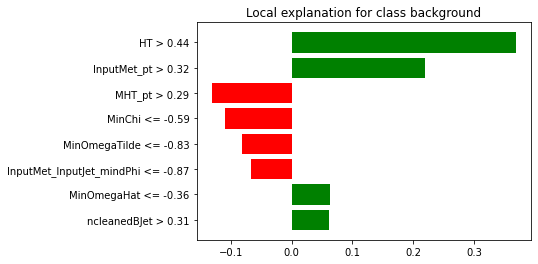

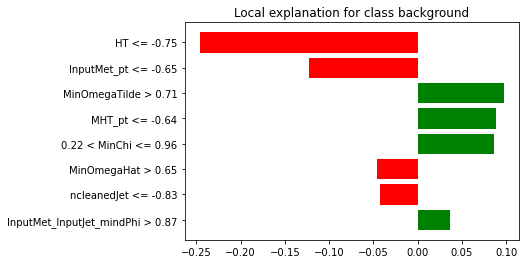

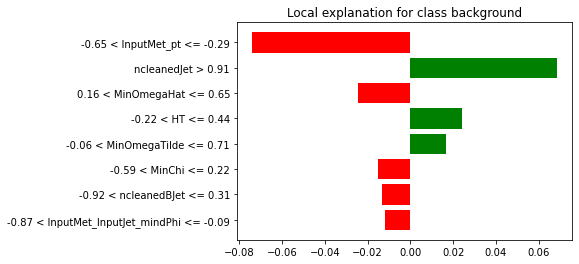

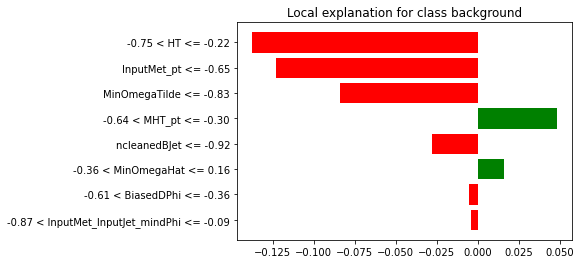

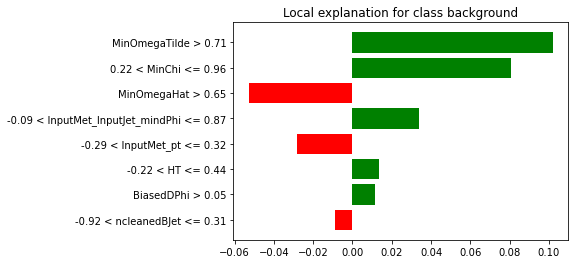

In [52]:
from lime import submodular_pick

sp_obj = submodular_pick.SubmodularPick(explainer, X_test.values, method='sample', sample_size=20, num_features=8, num_exps_desired=5, predict_fn=model.predict)
[exp.as_pyplot_figure(label=0) for exp in sp_obj.sp_explanations]

High HT seems to indicate a signal whereas high totalJet_pt and MHT_pt seem to indicate background